In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

<div class="alert alert-block alert-info">NB: This notebook appears to require Pytorch 0.4.</div>

In [2]:
import torch
torch.__version__

'0.4.0'

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *



import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
#torch.cuda.set_device(1)    #1 for interactive, 0 for long jobs

## Pascal VOC

We will use the [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset. That server is quite slow, so download from [this mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/). There are two different competition/research datasets, from 2007 and 2012. We'll use the 2007 version. You can use the larger 2012 for better results, or even combine them (but be careful to avoid data leakage between the validation sets if you do this).

## Preliminaries: Exploring the data

We are now using the python3 standard library `pathlib` for our paths and file access. Note that it returns an OS-specific class (on Linux, `PosixPath`) so your output may look a little different. Most libraries that take paths as input can take a pathlib object. But some (like `cv2`) can't,then use `str()` to convert it to a string.  [Pathlib Cheat sheet](http://path%20%3D%20path%28%27data/pascal%27%29%20list%28PATH.iterdir%28%29%29)

In [4]:
PATH = Path('data/pascal')
list(PATH.iterdir())

[PosixPath('data/pascal/.SRC'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/VOC2007_doc.pdf'),
 PosixPath('data/pascal/tmp'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/models')]

There are also hand-labeled *annotations* - *bounding boxes* showing where each object is. The original version were in XML, (a little hard to work with nowadays), so we use a more recent JSON version available from [this link](https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip).

You can see here how `pathlib` includes the ability to open files (amongst many other capabilities).

In [5]:
trn_j = json.load((PATH/'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [6]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
len(trn_j[IMAGES]), len(trn_j[ANNOTATIONS]), len(trn_j[CATEGORIES])     # how many we have?

(2501, 7844, 20)

In [7]:
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
 {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
 {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]

Annotations fields:
- bbox : column, row (of top left), height, width
- image_id : you’d have join this up with trn_j[IMAGES] (above) to find file_name etc.
- category_id : see trn_j[CATEGORIES] (below)
- segmentation : polygon segmentation (we will be using them)
- ignore : we will ignore the ignore flags
- iscrowd : specifies that it is a crowd of that object, not just one of them

In [8]:
trn_j[ANNOTATIONS][:2]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0}]

In [9]:
trn_j[CATEGORIES][:4]

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'}]

It's helpful to use constants instead of strings, since we get tab-completion and don't mistype.

In [10]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = {o[ID]:o['name'] for o in trn_j[CATEGORIES]}
trn_fns = {o[ID]:o[FILE_NAME] for o in trn_j[IMAGES]}
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [11]:
cats  # The categories

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

## Look at the images

In [12]:
list((PATH/'VOCdevkit'/'VOC2007').iterdir())  # We will use the 2007 set

[PosixPath('data/pascal/VOCdevkit/VOC2007/Annotations'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationObject'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages')]

In [13]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [14]:
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/008795.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/008222.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/008472.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005647.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/001959.jpg')]

Each image has a unique ID.

In [15]:
im0_d = trn_j[IMAGES][0]    # pick the first one
im0_d[FILE_NAME], im0_d[ID] # file name and id

('000012.jpg', 12)

**COORDINATES** In computer vision, “my screen is 640 by 480” == 640 width by 480 height. But, in math, “my array is 640 by 480” means 640 rows by 480 columns. 
The Python Image Library (PIL) tends to do things a-la-vision, ie, in width by height or columns by rows. 
But numpy is 'a-la-math' rows by columns.  

Here we are going to describe images using the top-left xy coordinate and the bottom right xy coordinate, 
rather than Pascal's way of top left x, y, height, width.

A `defaultdict` is useful any time you want to have a default dictionary entry for new keys. 
Below we create a dict from image IDs to a list of annotations (tuple of bounding box and class id).
If we "access" a key that doesn’t exist, it "magically" makes itself exist and it sets itself equal to the return value of the function you specify (in this case lambda:[]).

`trn_anno` will be the translated annotations using the preferred format of JH.
We convert VOC's height/width into top-left/bottom-right, and switch x/y coords to be consistent with numpy.
TL = Top Left, BR = Bottom Right
- `bbox` : TL.column, TL.row, height, width
- `hw_bb`: TL.row, TL.column, BR.row = (TL.row + width -1), BR.column = (TL.column + height - 1)

In [16]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX] # pull the box
        bb = hw_bb(bb) # translate as above
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
        
len(trn_anno)   # number of entries in the dictionary for the trainning annotations.

2501

In [17]:
o[IMG_ID]

9961

In [18]:
p=0; q=0
for i in trn_j[ANNOTATIONS]: 
    if i['ignore']: p +=1
    else: q += 1
print("Ignored annotations:",p, "Used annotations:", q, "TOTAL:", len(trn_j[ANNOTATIONS]))

Ignored annotations: 1543 Used annotations: 6301 TOTAL: 7844


In [19]:
im_a = trn_anno[im0_d[ID]]; im_a   # pick up the annotation for the one chosen before 

[(array([ 96, 155, 269, 350]), 7)]

In [20]:
im0_a = im_a[0]; im0_a   # an alternative reference to the same

(array([ 96, 155, 269, 350]), 7)

In [21]:
cats[7]   # what is the category of the annotation?

'car'

In [22]:
trn_anno[17]   # Lets pick another annotation, this one has 2 boxes

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

In [23]:
cats[15], cats[13]  # and here are the categories

('person', 'horse')

### Convert back
Some libs take VOC format bounding boxes, so this lets us convert back when required:

In [24]:
bb_voc = [155, 96, 196, 174]
bb_fastai = hw_bb(bb_voc)

In [25]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])   # bounding-box to height-width

In [26]:
f'expected: {bb_voc}, actual: {bb_hw(bb_fastai)}'

'expected: [155, 96, 196, 174], actual: [155  96 196 174]'

In [27]:
im = open_image(IMG_PATH/im0_d[FILE_NAME])   # open_image to later display it.

Fastai `open_image()` uses OpenCV. 
See cheet-sheat notebook for details... Warning: Using Pillow or Pytorch will slow things down a lot (not multi-threaded).

Matplotlib's `plt.subplots` is a useful wrapper for creating plots, regardless of whether you have more than one subplot. It returns an axis on the 2nd parameter.  `show_img` uses some of the OO API of Matplotlib.

In [28]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)   # if it was not passed, create one
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

A simple (but rarely used) trick to making text (or bounding lines) more visible regardless of background is to use white text with black outline, or visa versa. Here's how to do it in matplotlib.

In [29]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

Note that `*` in argument lists is the [splat operator](https://stackoverflow.com/questions/5239856/foggy-on-asterisk-in-python). In this case it's a little shortcut compared to writing out `b[-2],b[-1]`.

In [30]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [31]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

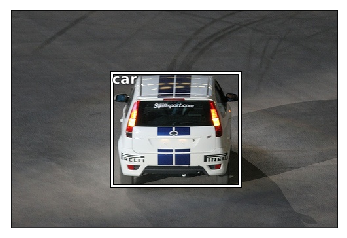

In [32]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])  # b[:2] is the top left

In [33]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [34]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

(364, 480, 3)


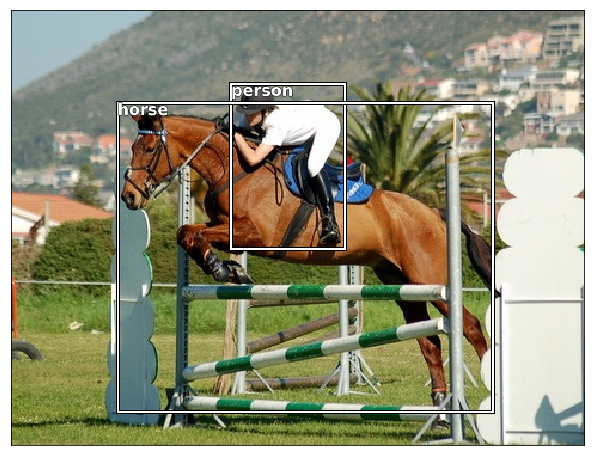

In [35]:
draw_idx(17)

## Largest item classifier

A *lambda function* is simply a way to define an anonymous function inline. Here we use it to describe how to sort the annotation for each image - by bounding box size (descending).

In `get_lrg` Bottom-right - Top-Left  x[0][-2:] -x [0][:2]

In [36]:
def get_lrg(b):
    if not b:raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [37]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()} # Key, a is imageid, value is the largest of b

In [38]:
%pdb

Automatic pdb calling has been turned ON


Now we have a dictionary `trn_lrg_anno` from image id to a single bounding box - the largest for that image.

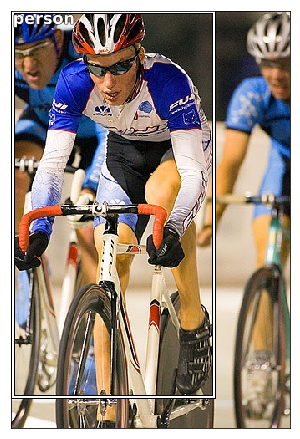

In [39]:
p = 23  # Cyclist
b,c = trn_lrg_anno[p]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[p]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

In [40]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

**Best Practice:** Often it's easiest to simply create a CSV of the data you want to model, rather than trying to create a custom dataset. Here we use Pandas to help us create a CSV of the image filename and class.

In [41]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
    'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

In [42]:
print(len(df))
df.head()

2501


fn        cat
0  000012.jpg        car
1  000017.jpg      horse
2  000023.jpg     person
3  000026.jpg        car
4  000032.jpg  aeroplane

In [43]:
f_model = resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(trn_fns))

From here it's just like Dogs vs Cats!

Notice that `crop_type=CropType.NO` , i.e. we will not crop the image. 
Previously we were cropping... because the items where mostly big and in the middle of the image.
But for bounding boxes we do not want to do that.
Usually models work better with crop rather than squish... but here it is ok.

The default strategy for creating 224 by 224 image in fast.ai is to first resize it so that the smallest side is 224. Then to take a random squared crop during the training. During validation, we take the center crop unless we use data augmentation.

For bounding boxes, we do not want to crop because (unlike an Imagenet where the thing we care about is pretty much in the middle and pretty big), a lot of the things in object detection are quite small and close to the edge. By setting crop_type to CropType.NO, it will not crop and therefore, to make it square, it squishes it [1:32:09]. 

In [44]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms)

Inside `md` (a model data object), we have (among other things) a training data loader and training data set. 
The data loader is an iterator that each time you grab the next iteration of stuff from it, you get a mini batch. The mini batch is of the size you asked for (default batch size is 64). In Python, we grab the next thing from an iterator with next `next`(md.trn_dl) but we can’t just do that, we need to “start a new epoch now”. 
In general, for any Python iterator, we need to say “start at the beginning of the sequence please”. 
We do that by using `iter`(md.trn_dl) which will grab an iterator out of md.trn_dl.
The class has to have defined an __iter__ method which returns some different object which then has an __next__ method.

To grab just a single batch, we do it as below, where (x: independent variable, y: dependent variable):

In [45]:
x,y=next(iter(md.val_dl))   # the data loader gives a minibatch of the size bs

NB: We canot send x as-is to `show_image`. x is not an np.array, it is not in the GPU, and its shape is "wrong"
(3x224x224). 


In [46]:
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

Furthermore, they are not numbers between 0 and 1 (see below). However, all of the standard ImageNet pre-trained models expect data to have been normalized to have a zero mean and 1 standard deviation.

In [47]:
x[0]

tensor([[[ 3.9125e-01,  4.3014e-01,  4.8172e-01,  ...,  1.7518e-01,
           3.2367e-01,  4.0783e-01],
         [ 5.1636e-01,  4.4973e-01,  5.9202e-01,  ...,  1.7386e-01,
           2.3164e-01,  3.6722e-01],
         [ 5.4416e-01,  5.7267e-01,  7.0099e-01,  ...,  5.7682e-02,
           2.2320e-01,  3.5455e-01],
         ...,
         [ 1.4604e+00,  1.5029e+00,  1.5195e+00,  ...,  7.8030e-01,
           5.6716e-01, -6.3922e-01],
         [ 9.3739e-01,  1.0210e+00,  1.1599e+00,  ...,  1.1281e+00,
           1.0895e+00,  4.5857e-01],
         [ 5.8584e-01,  4.5245e-01,  2.9605e-01,  ...,  1.0003e+00,
           9.2495e-01,  8.2729e-01]],

        [[ 2.4041e-01,  3.1444e-01,  4.1422e-01,  ...,  3.3162e-01,
           4.7052e-01,  5.4764e-01],
         [ 3.9737e-01,  4.2156e-01,  5.7304e-01,  ...,  3.3887e-01,
           3.8799e-01,  5.2038e-01],
         [ 5.2462e-01,  5.8245e-01,  6.7485e-01,  ...,  2.5190e-01,
           4.0003e-01,  5.1502e-01],
         ...,
         [ 1.4721e+00,  1

Several things must be done to the input to get it ready to be passed to a pre-trained model. 
`denorm()`  does the denormalize and also fixes up dimension order, etc. 
Since denormalization depends on the transform [1:37:52], and the dataset knows what transform was used to create it.
So we invoke `md.val_ds.denorm` and pass it the mini-batch after turning it into numpy array:

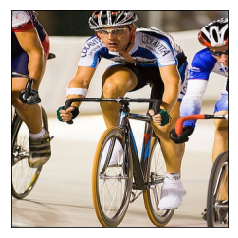

In [48]:
show_img(md.val_ds.denorm(to_np(x))[0]);

## Start Deep Learning as usual

In [49]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

/home/german/fastai/courses/dl2/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


### Learning Rate

In [50]:
lrf=learn.lr_find(1e-5,100)

 78%|███████▊  | 25/32 [00:05<00:01,  4.24it/s, loss=10.6]


When you LR finder graph looks like this, you can ask for more points on each end:

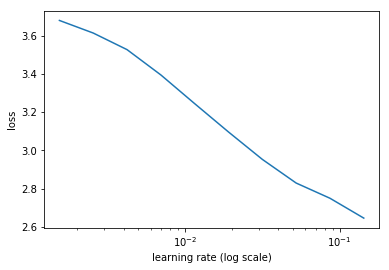

In [51]:
learn.sched.plot()

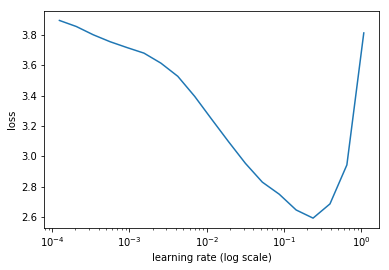

In [52]:
learn.sched.plot(n_skip=5, n_skip_end=1)   # now it looks better.

In [53]:
lr = 2e-2

### Fit

In [54]:
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.29701    0.606527   0.818     



[0.6065268223285675, 0.8180000023841858]

In [55]:
lrs = np.array([lr/1000,lr/100,lr])

In [56]:
learn.freeze_to(-2)

 84%|████████▍ | 27/32 [00:08<00:01,  3.33it/s, loss=4.58] 


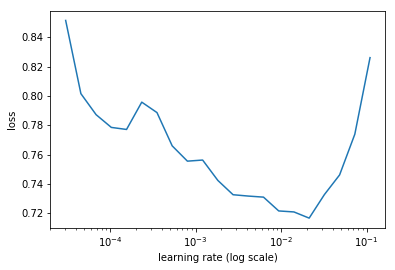

In [57]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [58]:
learn.fit(lrs/5, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.772838   0.58029    0.814     



[0.5802900874614716, 0.8140000009536743]

In [59]:
learn.unfreeze()

Accuracy isn't improving much - since many images have multiple different objects, it's going to be impossible to be that accurate.

In [60]:
learn.fit(lrs/5, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.594077   0.56811    0.83      
    1      0.423289   0.548911   0.836                     



[0.5489110615253449, 0.8360000009536743]

In [61]:
learn.save('clas_one')

In [62]:
learn.load('clas_one')

In [63]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

You can use the python debugger `pdb` to step through code.

- `pdb.set_trace()` to set a breakpoint
- `%debug` magic to trace an error

Commands you need to know:

- s / n / c
- u / d
- p
- l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


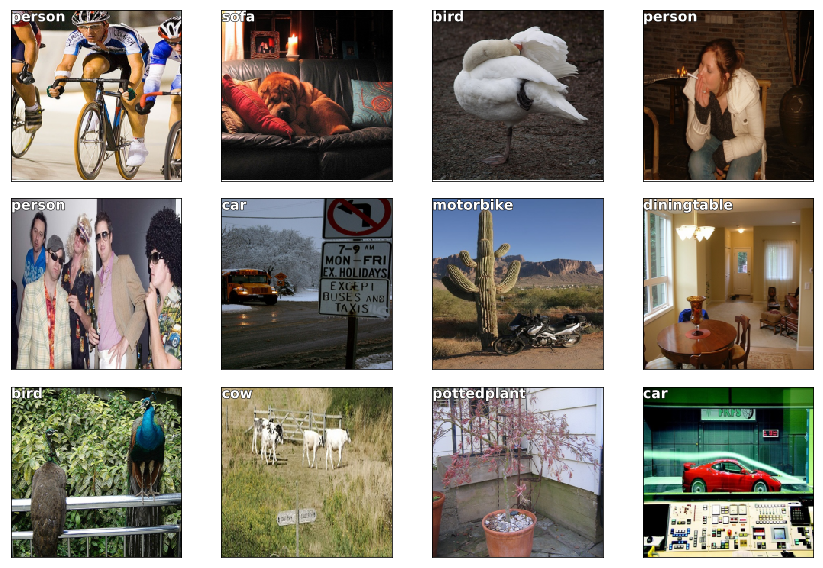

In [64]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

It's doing a pretty good job of classifying the largest object!

## Bbox only

Creating a bounding box around the largest object may seem like something new...
but it is not. 
We can create a `regression` rather than a classification neural net. 
`Classification` neural net is the one that has a sigmoid or softmax output, and we use a cross entropy, binary cross entropy, or negative log likelihood loss function. That is basically what makes it classifier. 
If we don’t have the softmax or sigmoid at the end and we use mean squared error as a loss function, it is now a `regression` model which predicts a continuous number rather than a category. 
We also know that we can have multiple outputs (like in the planet competition, multiple classification). 
Lets combine the two ideas and do a multiple column regression.

Now we'll try to find the bounding box of the largest object. 
This is simply a regression with 4 outputs. So we can use a CSV with multiple 'labels'.
Thinking about it like `differentiable programming`. 
It is not *“how do I create a bounding box model?”* but rather: 
We need 4 numbers, therefore, we need a NN with 4 activations
For loss function, we need  a function that when it is lower means that the four numbers are better? 
Mean squared loss function!

In [65]:
BB_CSV = PATH/'tmp/bb.csv'

In [66]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)

In [67]:
BB_CSV.open().readlines()[:5]   # Review the format, where the multiple labels are space separated.

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

In [68]:
f_model=resnet34
sz=224
bs=64

Set `continuous=True` to tell fastai this is a regression problem, which means it won't one-hot encode the labels, and will use MSE as the default crit.

Note that we have to tell the transforms constructor that our labels are coordinates, so that it can handle the transforms correctly.

Also, we use CropType.NO because we want to 'squish' the rectangular images into squares, rather than center cropping, so that we don't accidentally crop out some of the objects. (This is less of an issue in Imagenet, where there is a single object to classify, and it's generally large and centrally located).

## Augmentations

fastai augmentations all start with (prefix) Random

In [69]:
augs = [RandomFlip(), 
        RandomRotate(30),
        RandomLighting(0.1,0.1)]

**NB: Awkward terminology in fastai:**
A **classifier** is anything with dependent variable is categorical or binomial. 
**Regression** is anything with dependent variable is continuous. 
fastai naming is now confusing but will be fixed, eventually. 
Here, continuous is True because our dependent variable is the coordinates of a bounding box — 
hence the model generated is actually a regressor, not a classifier....

In [70]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

In [71]:
x,y = next(iter(md.val_dl))  # get a minibatch of data

In [72]:
idx=3
ima=md.val_ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[idx]))
print(b)

[115.  63. 241. 312.]


[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]


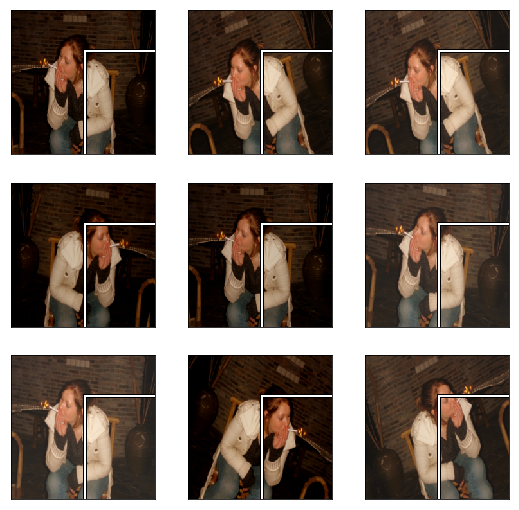

In [73]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

The image gets rotated and lighting varies, but bounding box is (a) not moving and (b) is in a wrong spot [6:17]. 
This is the problem with data augmentations when your dependent variable is pixel values or in some way connected to the independent variable — they need to be augmented together. 
As you can see in the bounding box coordinates [ 115. 63. 241. 312.] , our image is 224 by 224 — so it is neither scaled nor cropped. 
The dependent variable needs to go through all the geometric transformation as the independent variables.

To do this [7:10], every transformation has an optional `trm_y` parameter, which takes a TfmType enum value,
which has several option. The `TfmType.COORD` indicates that the y value represents coordinate. This needs to be added to all the augmentations as well as tfms_from_model which is responsible for cropping, zooming, resizing, padding, etc.

In [74]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        RandomRotate(30, tfm_y=tfm_y),
        RandomLighting(0.1,0.1, tfm_y=tfm_y)]

In [75]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

[ 52.  38. 106. 183.]
[ 52.  38. 106. 183.]
[ 55.  24. 132. 199.]
[ 48.  33. 116. 190.]
[ 37.  24. 131. 199.]
[ 52.  38. 106. 183.]
[ 47.  12. 153. 211.]
[ 49.  26. 133. 197.]
[ 38.  20. 150. 203.]


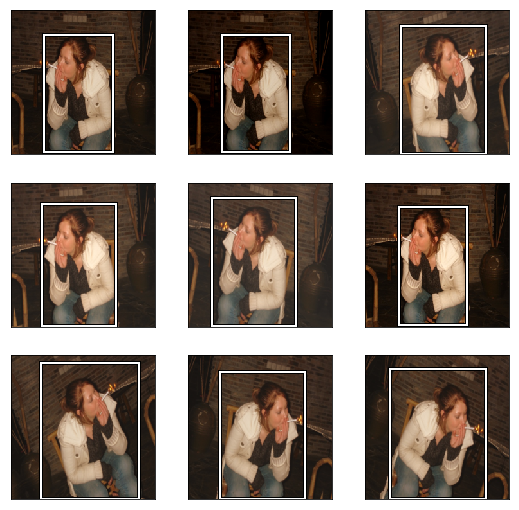

In [76]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

Now, the bounding box moves with the image and is in the right spot. You may notice that sometimes it looks odd like the middle on in the bottom row. This is the constraint of the information we have. If the object occupied the corners of the original bounding box, your new bounding box needs to be bigger after the image rotates. So you must be careful of not doing too "higher" rotations with bounding boxes because there is not enough information for them to stay accurate. If we were doing polygons or segmentations, we would not have this problem.

In [77]:
augs = [RandomFlip(tfm_y=tfm_y),
        RandomRotate(3, p=0.5, tfm_y=tfm_y),
        RandomLighting(0.05,0.05, tfm_y=tfm_y)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True)

So here, we do a maximum of 3 degree rotation to avoid this problem [9:14]. It also only rotates half of the time (p=0.5).

## Custom Head
fastai let's you use a `custom_head` to add your own module on top of a convnet, instead of the adaptive pooling and fully connected net which is added by default. In this case, we don't want to do any pooling, since we need to know the activations of each grid cell.

The final layer has 4 activations, one per bounding box coordinate. Our target is continuous, not categorical, so the MSE loss function used does not do any sigmoid or softmax to the module outputs.

Normally the previous layer has 7x7x512 in ResNet34, so flatten that out into a single vector of length 2508

In [78]:
512*7*7

25088

In [79]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

NB: Rather than adding up the squared errors, we add up the absolute values of the errors. 
Adding up the squared errors really penalizes bad misses by too much. So `L1Loss` is generally better to work with.

`learn.summary()` will run a small batch of data through a model and prints out the size of tensors at every layer. As you can see, right before the Flatten layer, the tensor has the shape of 512 by 7 by 7. So if it were a rank 1 tensor (i.e. a single vector) its length will be 25088 (512 * 7 * 7), and that is why our custom header’s input size is 25088. Output size is 4 since it is the bounding box coordinates.

In [80]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape

 78%|███████▊  | 25/32 [00:07<00:02,  3.26it/s, loss=396] 


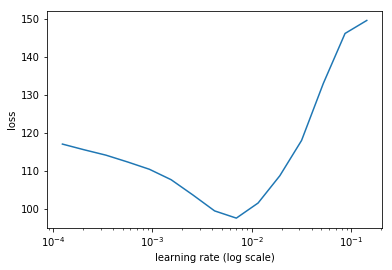

In [81]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [82]:
lr = 2e-3

In [83]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      49.209877  34.138314 
    1      37.505102  28.425968                           
    2      31.738557  27.632745                           



[27.63274461364746]

In [84]:
lrs = np.array([lr/100,lr/10,lr])

In [85]:
learn.freeze_to(-2)

epoch      trn_loss   val_loss                            
    0      85.347051  159864898111668.22



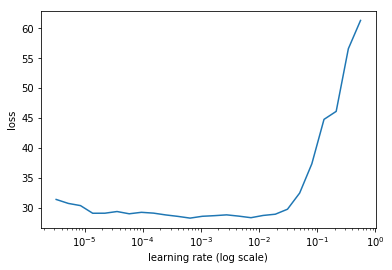

In [86]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [87]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      26.994191  24.465671 
    1      24.020883  23.101888                           
    2      20.632702  20.139192                           



[20.13919206237793]

In [88]:
learn.freeze_to(-3)

In [89]:
learn.fit(lrs, 1, cycle_len=2)

epoch      trn_loss   val_loss                            
    0      19.120575  21.157352 
    1      16.70877   19.472569                           



[19.472569259643556]

In [90]:
learn.save('reg4')

In [91]:
learn.load('reg4')

In [92]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


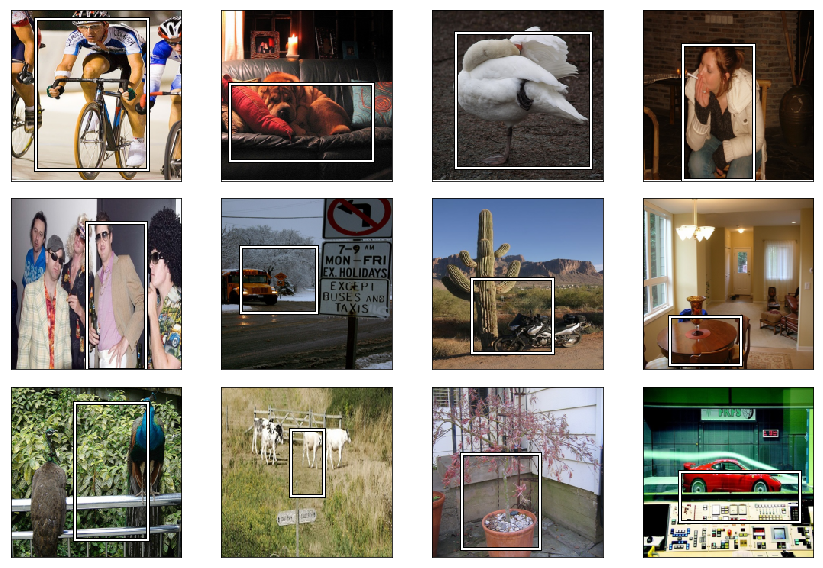

In [93]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

## Single object detection
Let’s combine the two to create something that can classify and localize the largest object in each image.

There are 3 things that we need to do to train a neural network:
1. Data
1. Architecture
1. Loss Function

###  Providing Data
We need a ModelData object whose independent variable is the images, and dependent variable is a tuple of bounding box coordinates and class labels. 
There are several ways to do this, but here is a particularly lazy and convinient way JH came up.<br>
Create two ModelData objects representing the two different dependent variables (`md` with bounding boxes coordinates, `md2` with classes).

<div class="alert alert-block alert-info">Tip: Use blue boxes for Tips and notes. If it’s a note, you don’t have to include the word “Note”.</div>

In [94]:
f_model=resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(trn_fns))

In [ ]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)

In [95]:
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
    continuous=True, val_idxs=val_idxs)

In [96]:
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

A dataset can be anything with `__len__` and `__getitem__` (indexer). <br>
Here's a dataset that adds a 2nd label to an existing dataset:

In [97]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

Above:
- ds : contains both independent and dependent variables
- y2 : contains the additional dependent variables
- (x, (y,self.y2[i])) : __getitem___ returns an independent variable and the combination of two dependent variables.
We’ll use it to add the classes to the bounding boxes labels.

We'll use it to add the classes to the bounding boxes labels.

In [98]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [99]:
val_ds2[0][1]   # has coordinates and label (14)

(array([  0.,  49., 205., 180.], dtype=float32), 14)

We can replace the dataloaders' datasets with these new ones.

In [100]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

We have to `denorm`alize the images from the dataloader before they can be plotted.

Below test these loaders with a minibatch of data to confirm that they work.

In [101]:
x,y=next(iter(md.val_dl))
idx=3
ima=md.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx])); b

array([ 52.,  38., 107., 185.])

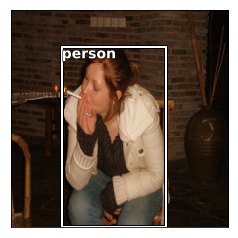

In [102]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][idx]])

###  (3) Choosing Architecture
The architecture will be the same as the one we used for the classifier and bounding box regression, but we will combine them.<br> 
If we have c classes, then the number of activations we need in the final layer is 4 plus c, ie `4 + len(cats)`.
4 for bounding box coordinates and c probabilities (one per class).

We’ll use an extra linear layer this time, plus some dropout, to help us train a more flexible model. 
In general, we want our custom head to be capable of solving the problem on its own if the pre-trained backbone it is connected to is appropriate. 
So in this case, we are trying to do quite a bit — classifier and bounding box regression, so just the single linear layer does not seem enough. 

If you were wondering why there is no BatchNorm1d after the first ReLU , ResNet backbone already has BatchNorm1d as its final layer.

We need one output activation for each class (for its probability) plus one for each bounding box coordinate. <br>
We'll use an extra linear layer this time, plus some dropout, to help us train a more flexible model.

In [103]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

Notice that after the first nn.relu there is no Batchnorm.  JH checked and Resnet already has it, so it is not necessary. Similar to the head before... more complex.

### Loss Function 
[15:46]
The loss function needs to look at these 4 + len(cats) activations and decide if they are good — whether these numbers accurately reflect the position and class of the largest object in the image. 
For the first 4 activations, we will use `L1Loss` just like we did before (L1Loss is like a Mean Squared Error — instead of sum of squared errors, it uses sum of absolute values). 
For rest of the activations, we can use cross entropy loss.

Pytorch loss-functions always call the input parameters: input and a target.

In [110]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

- input : activations
- target : ground truth

- bb_t is bounding box coordinates of target
- c_t are the classes of the target 
- bb_i is the bounding box of the input
- c_i is the classes probabilities of the input

- bb_t,c_t = target : This assignment will destructure the classes accordingly.

- bb_i,c_i = `input[:, :4], input[:, 4:]` :  the first ":" is for the batch dimension, then the corresponding 4  from the input is for the dimension and classes.

- b_i = `F.sigmoid(bb_i)*224` : we know our image is 224 by 224. Sigmoid will force it to be between 0 and 1, and multiply it by 224 to help our neural net to be in the range of what it has to be.

With the inputs and targets, we can calculate the L1 loss and add the cross entropy [20:39]:

`F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20`

This is our loss function. Cross entropy and L1loss may be of wildly different scales — in which case in the loss function, the larger one is going to dominate. 
Jeremy looked at the values and found out that if we multiply cross entropy by 20 that makes them about the same scale.  (**TODO: Is there a good function to do such calibration automatically?**)

 97%|█████████▋| 31/32 [00:08<00:00,  3.67it/s, loss=914]


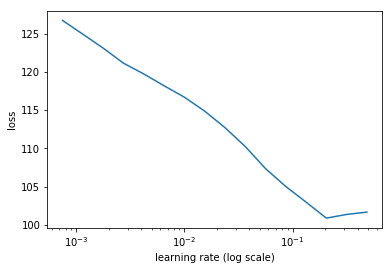

In [106]:
learn.lr_find()
learn.sched.plot()

In [107]:
lr=1e-2

LooseVersion ('0.4.0')

Below hiting a y.data reference inside model.py... Could it be pyTorch 0.4 related?

In [111]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      44.923298  39.698085  0.79       26.765987 
    1      40.298016  36.104863  0.818      24.649712     
    2      35.828485  34.754274  0.822      24.076124     



[34.75427392578125, 0.8220000023841858, 24.076123962402345]

In [ ]:
#%debug

In [112]:
learn.save('reg1_0')

In [113]:
learn.freeze_to(-2)

In [114]:
lrs = np.array([lr/100, lr/10, lr])

 91%|█████████ | 29/32 [00:08<00:00,  3.28it/s, loss=239] 


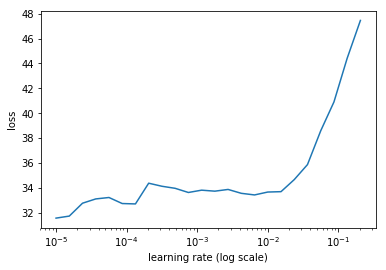

In [115]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [116]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      34.041392  37.653772  0.798      22.94684  
    1      30.415948  32.538278  0.83       20.896619     
    2      26.827487  32.083566  0.826      20.463843     
    3      23.609583  31.030754  0.836      19.854157     
    4      21.586625  31.01973   0.836      19.731635     



[31.01973013305664, 0.8359999995231628, 19.731635360717775]

In [117]:
learn.save('reg1_1')

In [118]:
learn.load('reg1_1')

In [119]:
learn.unfreeze()

In [120]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      18.736584  30.494332  0.854      19.558798 
    1      18.440487  31.217771  0.844      19.5566       
    2      17.806266  30.959917  0.844      19.334848     
    3      17.230907  30.312609  0.834      19.075592     
    4      16.440873  30.082327  0.85       19.124154     
    5      15.453464  30.132797  0.84       18.814457     
    6      14.811117  30.133377  0.834      18.734139     
    7      14.402318  29.831624  0.842      18.586108     
    8      13.808873  29.944504  0.836      18.465745     
    9      13.290157  29.99962   0.836      18.457196     



[29.99961961364746, 0.8359999980926514, 18.457195930480957]

Detection accuracy is in the low 80’s (same as before). This is not surprising because ResNet was designed to do classification, so we wouldn’t expect to be able to improve things in such a simple way. 
It certainly wasn’t designed to do bounding box regression. 
It was explicitly actually designed in such a way to not care about geometry — it takes the last 7 by 7 grid of activations and averages them all together throwing away all the information about where everything came from.

Interestingly, <font color=blue>when we do accuracy (classification) and bounding box at the same time, the L1 seems a little bit better than when we just do bounding box regression</font> 
[22:46]. 
If this is counterintuitive, think about it... is a really important idea. 
The idea is this — figuring out what the main object in an image is, is kind of the hard part. 
Then figuring out exactly where the bounding box is and what class it is, is the easy part. 
We have a single network that’s both saying what is the object and where is the object, it’s going to share all the computation about finding the object. 
That shared computation is very efficient. 
When we back propagate the errors in the class and in the place, that’s all the information that is going to help the computation around finding the biggest object. 
We have multiple tasks which share some concept of what those tasks would need to do to complete their work, it is very likely they should share at least some layers of the network together. 
Later today, we will look at a model where most of the layers are shared except for the last one.

In [121]:
learn.save('reg1')

In [122]:
learn.load('reg1')

In [123]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

The `expit` function, also known as the logistic function, is defined as expit(x) = 1/(1+exp(-x)). It is the inverse of the logit function.

In [124]:
from scipy.special import expit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


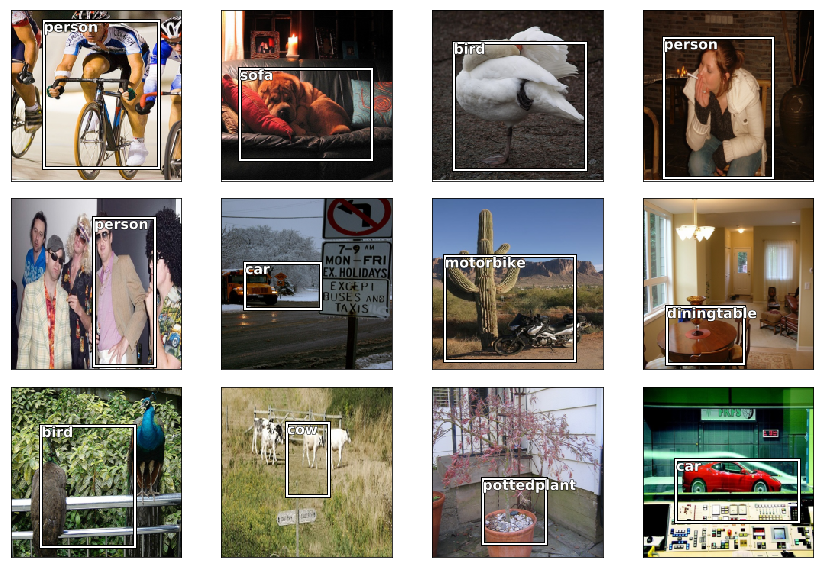

In [125]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])
plt.tight_layout()

Here are the result [24:34]. 
As before, it does a good job when there is single major object in the image.

## End